In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-ii/online_retail_II.xlsx


In [3]:
##############################################################
# Project: Customer Life Time Value Prediction with BG-NBD and Gamma-Gamma
##############################################################
# Data Set Information:
# This Online Retail II data set contains all the transactions occurring for a UK-based and registered,
# non-store online retail between 01/12/2009 and 09/12/2011. The company mainly sells unique all-occasion gift-ware.
# Many customers of the company are wholesalers.

# Invoice: Invoice number. if the invoice values contain 'C' it means return
# StockCode: Product (item) code.
# Description: Product (item) name.
# Quantity: The quantities of each product (item) per Invoice.
# InvoiceDate: Invoice date and time.
# UnitPrice: Unit price.
# CustomerID: Customer number.
# Country: Country name.
############################################


In [4]:
pip install lifetimes

     |████████████████████████████████| 584 kB 420 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install openpyxl

     |████████████████████████████████| 243 kB 420 kB/s eta 0:00:01
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=a443f9682a0582b236ab50bc08d7f0b6aeceec53902a03218f7fd6466b0052b7
  Stored in directory: /root/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile
Note: you may need to restart the kernel to use updated packages.


In [6]:
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_frequency_recency_matrix

In [7]:
df_ = pd.read_excel("../input/online-retail-ii/online_retail_II.xlsx",
                   sheet_name="Year 2010-2011")

In [19]:
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0,9.552234,218.080957,-80995.00,1.00,3.00,10.00,80995.0
Price,541910.0,4.611138,96.759765,-11062.06,1.25,2.08,4.13,38970.0
Customer ID,406830.0,15287.684160,1713.603074,12346.00,13953.00,15152.00,16791.00,18287.0


In [22]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [23]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [24]:
# Replace outlier 
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0,7.275479,153.626473,-80995.00,1.00,3.00,10.00,71.000
Price,541910.0,3.253448,21.549925,-11062.06,1.25,2.08,4.13,24.245
Customer ID,406830.0,15287.684160,1713.603074,12346.00,13953.00,15152.00,16791.00,18287.000


In [26]:
# looking NaN
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [27]:
# Delete missing values
df.dropna(inplace=True)

In [28]:
# Delete return invoice and negative quantity
df = df[~df["Invoice"].str.startswith("C", na=False)]
df = df[df["Quantity"] > 0]

In [29]:
# Calculate Total Price
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397925.0,10.087625,13.864911,1.0,2.00,6.00,12.00,71.000
Price,397925.0,2.867411,3.000686,0.0,1.25,1.95,3.75,24.245
Customer ID,397925.0,15294.308601,1713.172738,12346.0,13969.00,15159.00,16795.00,18287.000
TotalPrice,397925.0,18.212033,30.230544,0.0,4.68,11.80,19.80,1721.395


In [31]:
# Check data
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [32]:
# Creating RFM Metrics
df["InvoiceDate"].max()
today_date = dt.datetime(2011, 12, 11)


rfm = df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (today_date - date.max()).days,
                                                     lambda date: (today_date - date.min()).days],
                                     'Invoice': lambda num: num.nunique(),
                                     'TotalPrice': lambda price: price.sum()})


rfm.columns = rfm.columns.droplevel(0)
rfm.columns = ['Recency', "Tenure", 'Frequency', "Monetary"]
rfm.head()

,Recency,Tenure,Frequency,Monetary
Customer ID,,,,
12346.0,326,326,1,73.840
12347.0,3,368,7,4134.240
12348.0,76,359,4,1307.015
12349.0,19,19,1,1466.090
12350.0,311,311,1,318.645


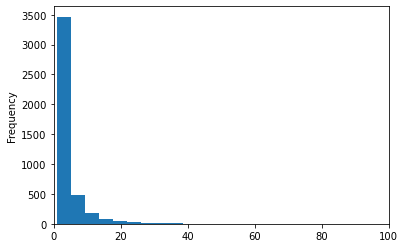

In [33]:
rfm['Frequency'].plot(kind='hist', bins=50, xlim=(0,100));

In [34]:
# Create Monetary avg

temp_df = df.groupby(["Customer ID", "Invoice"]).agg({"Invoice": "count", "TotalPrice": ["mean"]})
temp_df.head()
temp_df = temp_df.reset_index()

temp_df.columns = temp_df.columns.droplevel(0)
temp_df.columns = ["Customer ID", "Invoice", "total_price_count", "total_price_mean"]

temp_df2 = temp_df.groupby(["Customer ID"], as_index=False).agg({"total_price_mean": ["mean"]})
temp_df2.head()

temp_df2.columns = temp_df2.columns.droplevel(0)
temp_df2.columns = ["Customer ID", "monetary_avg"]

# Add monetary avg column to rfm dataframe
rfm.index.isin(temp_df2["Customer ID"]).all()   # check two dataframe Customer ID equal
rfm = rfm.merge(temp_df2, how="left", on="Customer ID")
rfm.set_index("Customer ID", inplace=True)
rfm.index = rfm.index.astype(int)
rfm.head()

,Recency,Tenure,Frequency,Monetary,monetary_avg
Customer ID,,,,,
12346,326,326,1,73.840,73.840000
12347,3,368,7,4134.240,22.050806
12348,76,359,4,1307.015,47.342973
12349,19,19,1,1466.090,20.083425
12350,311,311,1,318.645,18.743824


In [35]:
# delete negative monetary_avg values
rfm = rfm[(rfm['monetary_avg'] > 0)]

In [36]:
# convert daily values to weekly for recency and tenure
rfm["Recency_weekly"] = rfm["Recency"] / 7
rfm["T_weekly"] = rfm["Tenure"] / 7

In [37]:
# save point
rfm_cltv = rfm.copy()
rfm_cltv.head()

,Recency,Tenure,Frequency,Monetary,monetary_avg,Recency_weekly,T_weekly
Customer ID,,,,,,,
12346,326,326,1,73.840,73.840000,46.571429,46.571429
12347,3,368,7,4134.240,22.050806,0.428571,52.571429
12348,76,359,4,1307.015,47.342973,10.857143,51.285714
12349,19,19,1,1466.090,20.083425,2.714286,2.714286
12350,311,311,1,318.645,18.743824,44.428571,44.428571


In [38]:
# Assumptions of BG / NBD and gamma gamma model:
rfm_cltv[['monetary_avg', 'Recency_weekly']].corr()
rfm_cltv["Frequency"] = rfm_cltv["Frequency"].astype(int)

In [39]:
# BG/NBD Model
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(rfm_cltv['Frequency'],
        rfm_cltv['Recency_weekly'],
        rfm_cltv['T_weekly'])


<lifetimes.BetaGeoFitter: fitted with 4338 subjects, a: 1.52, alpha: 0.07, b: 5.69, r: 0.28>

In [40]:
# 1 month values
rfm_cltv["expected_number_of_purchases_1_month"] = bgf.predict(4,
                                                       rfm_cltv['Frequency'],
                                                       rfm_cltv['Recency_weekly'],
                                                       rfm_cltv['T_weekly'])

In [41]:
rfm_cltv.head()

,Recency,Tenure,Frequency,Monetary,monetary_avg,Recency_weekly,T_weekly,expected_number_of_purchases_1_month
Customer ID,,,,,,,,
12346,326,326,1,73.840,73.840000,46.571429,46.571429,8.516621e-02
12347,3,368,7,4134.240,22.050806,0.428571,52.571429,7.651826e-15
12348,76,359,4,1307.015,47.342973,10.857143,51.285714,2.436895e-03
12349,19,19,1,1466.090,20.083425,2.714286,2.714286,1.137201e+00
12350,311,311,1,318.645,18.743824,44.428571,44.428571,8.919197e-02


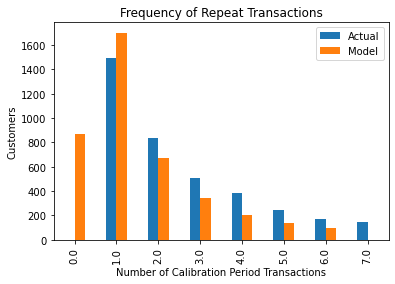

In [42]:
plot_period_transactions(bgf);

/opt/conda/lib/python3.7/site-packages/lifetimes/fitters/beta_geo_fitter.py:256: RuntimeWarning: overflow encountered in double_scalars
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


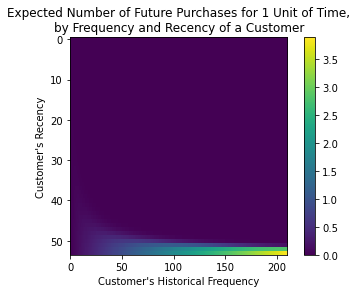

In [43]:
# Expected Number of Future Purchase for 1 Unit of time
plot_frequency_recency_matrix(bgf);

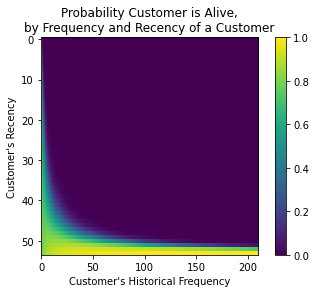

In [44]:
# Probability Customer is Alive
plot_probability_alive_matrix(bgf);

In [45]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [46]:
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [47]:
summary_cal_holdout = calibration_and_holdout_data(df, 'Customer ID', 'InvoiceDate',
                                        calibration_period_end='2011-03-08',
                                        observation_period_end='2011-12-9' )   
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346.0,0.0,0.0,49.0,0.0,276.0
12347.0,1.0,50.0,91.0,5.0,276.0
12348.0,1.0,40.0,82.0,2.0,276.0
12350.0,0.0,0.0,34.0,0.0,276.0
12352.0,1.0,13.0,20.0,5.0,276.0


/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:274: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


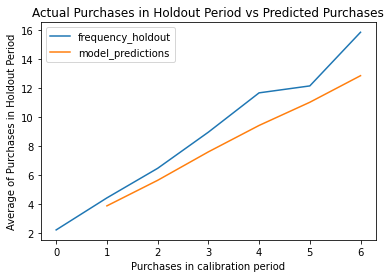

In [48]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'],
        summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);

In [49]:
# GAMMA-GAMMA Model
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(rfm_cltv['Frequency'], rfm_cltv['monetary_avg'])

<lifetimes.GammaGammaFitter: fitted with 4338 subjects, p: 3.62, q: 1.06, v: 3.33>

In [50]:
# looking top 10 expected average values
ggf.conditional_expected_average_profit(rfm_cltv['Frequency'],
                                        rfm_cltv['monetary_avg']).sort_values(ascending=False).head(10)

Customer ID
15098    589.832108
17291    537.567646
16000    438.245612
16716    353.707629
12823    351.400700
14424    320.102292
12980    312.216075
14145    306.051299
15649    300.920125
12917    295.431232
dtype: float64

In [51]:
# add expected average profit
rfm_cltv["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm_cltv['Frequency'],
                                                                              rfm_cltv['monetary_avg'])

In [52]:
# Prediction CLTV for 3 month

cltv = ggf.customer_lifetime_value(bgf,
                                   rfm_cltv['Frequency'],
                                   rfm_cltv['Recency_weekly'],
                                   rfm_cltv['T_weekly'],
                                   rfm_cltv['monetary_avg'],
                                   time=3,
                                   freq="W",
                                   discount_rate=0.01)

cltv.head()

Customer ID
12346    16.623821
12347    21.324430
12348    28.059439
12349     9.186531
12350     4.861966
Name: clv, dtype: float64

In [53]:
# Merge CLTV values to rfm dataframe
cltv = cltv.reset_index()
rfm_cltv_final = rfm_cltv.merge(cltv, on="Customer ID", how="left")
rfm_cltv_final.head()

,Customer ID,Recency,Tenure,Frequency,Monetary,monetary_avg,Recency_weekly,T_weekly,expected_number_of_purchases_1_month,expected_average_profit,clv
0,12346,326,326,1,73.840,73.840000,46.571429,46.571429,8.516621e-02,75.909957,16.623821
1,12347,3,368,7,4134.240,22.050806,0.428571,52.571429,7.651826e-15,22.473051,21.324430
2,12348,76,359,4,1307.015,47.342973,10.857143,51.285714,2.436895e-03,47.976218,28.059439
3,12349,19,19,1,1466.090,20.083425,2.714286,2.714286,1.137201e+00,23.029907,9.186531
4,12350,311,311,1,318.645,18.743824,44.428571,44.428571,8.919197e-02,21.712148,4.861966
